In [24]:
using Plots, Printf, DelimitedFiles, Random, Statistics, ProgressMeter
using MDToolbox
using BSON: @save, @load

In [25]:
qs = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
models = readpdb("data/t1r/cluster.pdb");
for iatom = 1:models.natom
    models.atomname[iatom] = models.resname[iatom]
end
MDToolbox.decenter!(models)

In [26]:
probe_radius = 30
param = AfmizeConfig(10.0 * (pi / 180),
    probe_radius, 
    MDToolbox.Point2D(-250, -200), 
    MDToolbox.Point2D(250, 200), 
    MDToolbox.Point2D(6.25, 6.25), 
    MDToolbox.defaultParameters())

AfmizeConfig(0.17453292519943295, 30.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("CZ3" => 1.7,"C" => 1.7,"P" => 1.8,"NE1" => 1.55,"GLY" => 2.25,"ASN" => 2.85,"CE3" => 1.7,"CG" => 1.7,"PHE" => 3.2,"CH2" => 1.7…))

In [27]:
myseed = 335
sigma_noise = 3.0
nq = size(qs, 1)
nframe = 1000
#nframe = nq*3
nmodel = models.nframe

50

In [28]:
seed = MersenneTwister(myseed)
rand(seed)

0.7643846982996265

In [29]:
function quate_dist(q1, q2)
    # return min(sum(q1 .+ q2) .^ 2, sum(q1 .- q2) .^ 2)
    # return acos(max(-1, min(1, 2.0 * sum(q1.*q2).^2 - 1.0)))
    return 1.0 - sum(q1.*q2)^2
end

quate_dist (generic function with 1 method)

In [30]:
T_rot = zeros(Float64, nq, nq)
for i in 1:nq
    ncount = 0
    for j in 1:nq
        d = quate_dist(qs[i, :], qs[j, :])
        if d < 0.01
            T_rot[i, j] = 1.0
            ncount += 1
        end
    end
    #@show ncount
    T_rot[i, :] .= T_rot[i, :] ./ ncount
end

In [31]:
@load "data/t1r/t1r.bson" T pi_i

imodel_array = msmgenerate(nframe+300, T, pi_i)
imodel_array = imodel_array[301:end, :]

p0_q = zeros(Float64, nq)
#p0_q[91] = 1.0
p0_q[30] = 1.0
iq_array = msmgenerate(nframe, T_rot, p0_q);
#for i = 1:nq
#    iq_array[(i-1)*2+1] = i
#    iq_array[(i-1)*2+2] = i
#    iq_array[(i-1)*2+3] = i
#end

dxdy_array = zeros(Float64, nframe, 2);

In [32]:
afms = []
@showprogress 1 "Computing..." for iframe in 1:nframe
    imodel = imodel_array[iframe]
    model = models[imodel, :]
    iq = iq_array[iframe]
    q = qs[iq, :]
    model = MDToolbox.rotate(model, q)
    model.x .+=  dxdy_array[iframe, 1]
    model.y .+=  dxdy_array[iframe, 2]
    afm = MDToolbox.afmize(model, param)
    h, w = size(afm)
    afm .+= randn(seed, h, w) * sigma_noise
    push!(afms, afm)
end

Computing...100%|███████████████████████████████████████| Time: 0:01:20


┌ Info: Saved animation to 
│   fn = /data/yasu/MDToolbox.jl/notebook/afm_generate_orientation_data.gif
└ @ Plots /opt/julia_depot/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/data/yasu/MDToolbox.jl/notebook/afm_generate_orientation_data.gif")
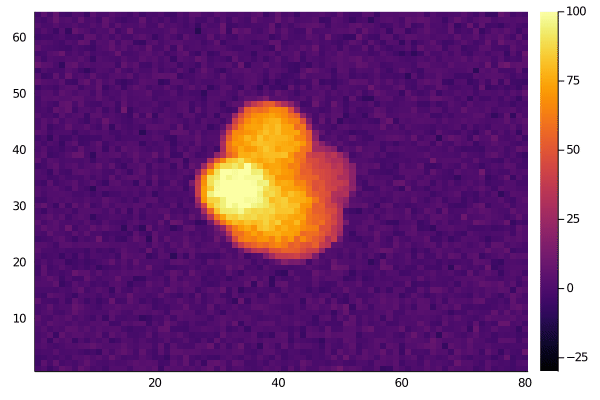

In [33]:
anim = @animate for i in 1:minimum([nframe, 50])
    heatmap(afms[i], clims=(-30.0, 100.0))
end
gif(anim, "afm_generate_orientation_data.gif", fps=10)

In [34]:
@save "afm_generate_orientation_data.bson" models afms qs param imodel_array iq_array dxdy_array sigma_noise probe_radius T pi_i T_rot p0_q nframe nq nmodel

In [35]:
# julia --machine-file=machinefile.txt afm_generate_orientation_data_posterior.jl